In [38]:
from neuralprophet import NeuralProphet, set_random_seed
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
import pandas as pd
import datetime
import numpy as np
import re
import matplotlib.pyplot as plt
#This should lead to identical results every time you run the model. 
# Note that you have to explicitly set the random seed to the same 
# random number each time before fitting the model.
set_random_seed(0)

#visualization
import seaborn as sns
sns.set_theme()

In [3]:
import matplotlib as mpl
import warnings

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

warnings.filterwarnings('ignore', category=FutureWarning)


In [4]:
def prep_data():
    #import data
    df = pd.read_csv("../bergen_florida_temperature_1957-2022.csv",\
                    sep=";", converters={"Tid(norsk normaltid)":str},
                    decimal=",")
    #rename columns
    df.rename(columns={"Tid(norsk normaltid)": "Date", "Middeltemperatur (mnd)": "mean_temp", 
                        "Middeltemperatur, avvik fra normalen 1991-2020 (mnd)": "mean_temp_deviation",
                        "Maksimumstemperatur (mnd)": "max_temp", "Minimumstemperatur (mnd)": "min_temp"}, 
                        inplace=True)

    #seperate month and year from Date column 
    # frm (MM.YYYY) to mm and YYYY
    month = []
    year = []
    for i in range(len(df)):
        month.append( re.findall( r'[0-9]+', str( df["Date"][i] ) ) [0] )
        year.append( re.findall( r'[0-9]+', str( df["Date"][i] ) ) [1] )

    #add month and year list into df 
    df["month"] = month
    df["year"] = year

    #convert month and year into numeric
    df["year"] = df["year"].astype("int")
    df["month"] = df["month"].astype("int")

    #create datatime column using month year
    #and new day column with 1
    df["day"] = "01"
    df["ds"] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day))
    
    #copy df for neuralprophet
    df_np = df.copy()

    return df, df_np

df, df_np = prep_data()
df.head()

,Navn,Stasjon,Date,mean_temp,mean_temp_deviation,max_temp,min_temp,month,year,day,ds
0,Bergen - Florida,SN50540,01.1957,3.8,1.2,9.6,-5.0,1,1957,01,1957-01-01
1,Bergen - Florida,SN50540,02.1957,2.3,0.0,9.6,-5.6,2,1957,01,1957-02-01
2,Bergen - Florida,SN50540,03.1957,5.4,1.6,14.5,-2.2,3,1957,01,1957-03-01
3,Bergen - Florida,SN50540,04.1957,6.3,-0.9,14.1,-1.0,4,1957,01,1957-04-01
4,Bergen - Florida,SN50540,05.1957,9.1,-1.6,20.8,1.4,5,1957,01,1957-05-01


Convert date to pandas datatime index for easy plots etc.

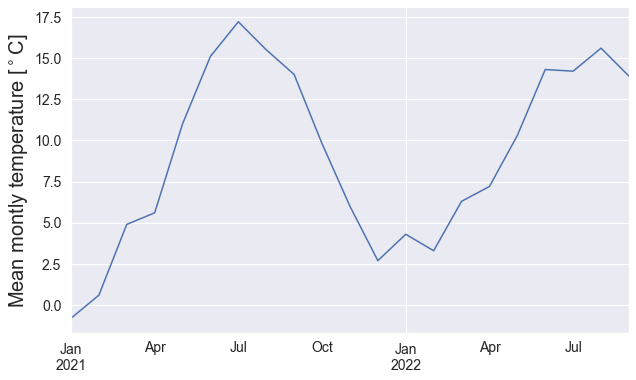

In [5]:
df["time"] = df["ds"].copy()
df.set_index("time", inplace=True)
df["mean_temp"].loc["2021":"2022"].plot()
plt.ylabel("Mean montly temperature [$^\circ$C]")
plt.xlabel("")
plt.show()

Check stationarity of time series

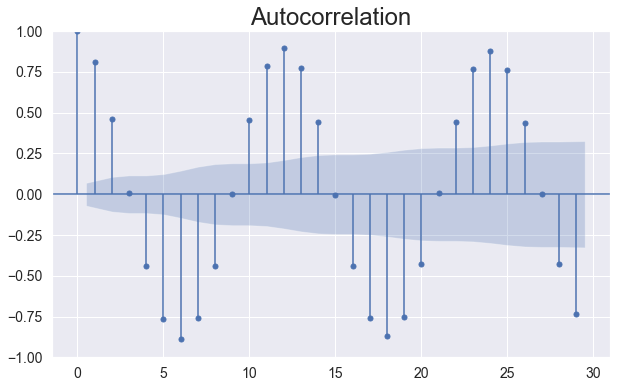

In [6]:
import statsmodels.api as smt

fig = smt.tsa.graphics.plot_acf(df["mean_temp"].values.squeeze())

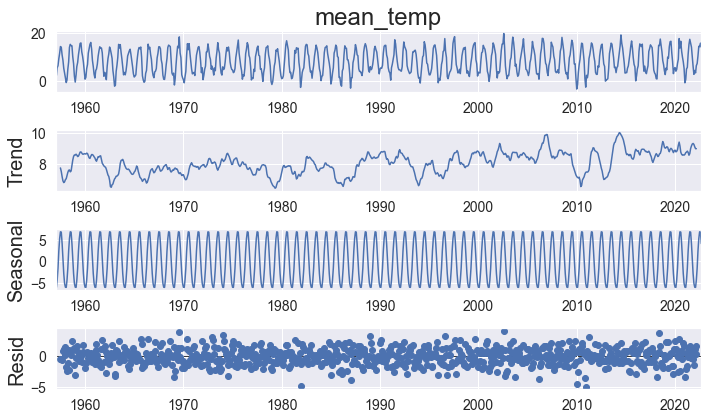

In [7]:
#Times series decomposition
#additive model Y(t) = Trend(t ) + Seasonality(t) + Residual(t)
#multiplicative model Y(t) = Trend(t ) * Seasonality(t) * Residual(t)

decompoisition = smt.tsa.seasonal_decompose(df["mean_temp"], model="additive")
fig = decompoisition.plot()

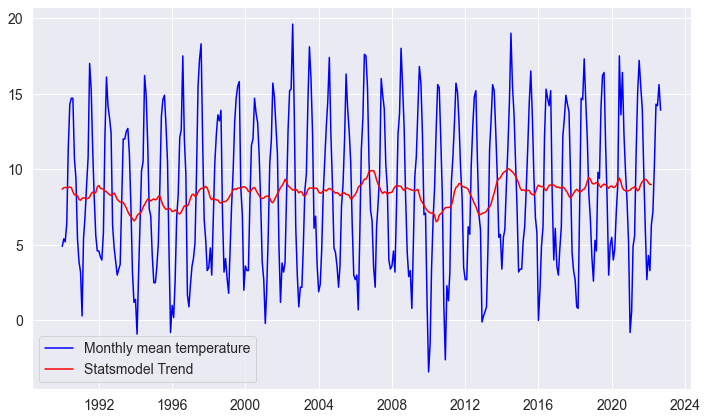

In [8]:
plt.plot(df["mean_temp"].loc["1990":"2022"], c="blue", label="Monthly mean temperature")
plt.plot(decompoisition.trend.loc["1990":"2022"], c="red", label="Statsmodel Trend")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
decompoisition.trend.loc["2021":"2022"]

time
2021-01-01    8.625000
2021-02-01    8.737500
2021-03-01    8.770833
2021-04-01    8.837500
2021-05-01    8.754167
2021-06-01    8.570833
2021-07-01    8.679167
2021-08-01    9.004167
2021-09-01    9.175000
2021-10-01    9.300000
2021-11-01    9.337500
2021-12-01    9.275000
2022-01-01    9.116667
2022-02-01    8.995833
2022-03-01    8.995833
2022-04-01         NaN
2022-05-01         NaN
2022-06-01         NaN
2022-07-01         NaN
2022-08-01         NaN
2022-09-01         NaN
Name: trend, dtype: float64

Preprocessing data with skits

In [10]:
from skits.preprocessing import (ReversibleImputer, DifferenceTransformer, HorizonTransformer)
from skits.pipeline import ForecasterPipeline
from sklearn.preprocessing import StandardScaler

In [11]:
pipeline = ForecasterPipeline([
    ("pre_differencer", DifferenceTransformer()),
    ("pre_diff_imputer", ReversibleImputer()),
    ("pre_scaler", StandardScaler())
])

y = df["mean_temp"].values
X = y.copy()[:, np.newaxis]
Xt = pipeline.fit_transform(X, y)

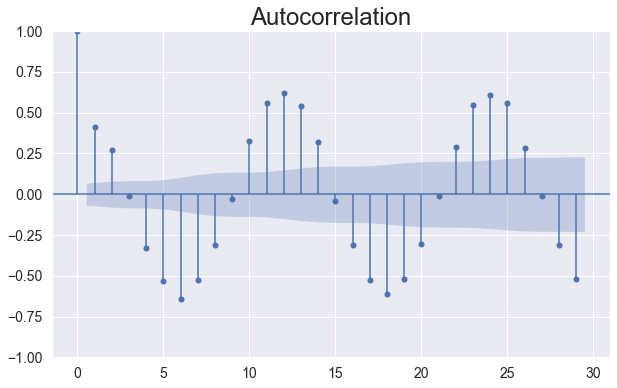

In [12]:
fig = smt.tsa.graphics.plot_acf(Xt.squeeze())

Fitting and predicting with skits 

In [13]:
from skits.feature_extraction import (AutoregressiveTransformer, SeasonalTransformer)
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import FeatureUnion

In [79]:
pipeline = ForecasterPipeline([
    ("pre_differencer", DifferenceTransformer()),
    ("pre_diff_imputer", ReversibleImputer()),
    ("pre_scaler", StandardScaler()),
    ("features", FeatureUnion([
        ("ar_features", AutoregressiveTransformer()),
        ("seasonal_features", SeasonalTransformer())
    ])),
    ("post_feature_imputer", ReversibleImputer()),
    ("post_feature_scaler", StandardScaler()),
    ("regressor", LinearRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X, y)

In [15]:
df.index[10:]

DatetimeIndex(['1957-11-01', '1957-12-01', '1958-01-01', '1958-02-01',
               '1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01',
               ...
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01'],
              dtype='datetime64[ns]', name='time', length=779, freq=None)

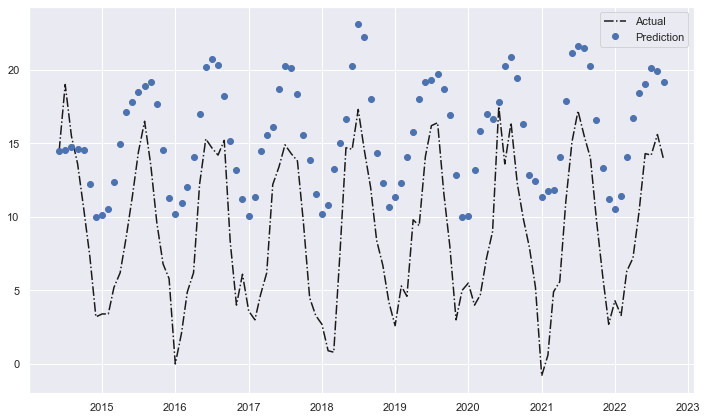

In [80]:
plt.plot(df.index[-100:], y[-100:], "k-.", label="Actual")
plt.plot(df.index[-100:], pipeline.predict(X[-100:], to_scale=True), "o", label="Prediction")
plt.legend()
plt.tight_layout()
plt.show()

Simple code in the previous pipeline

In [145]:
lr = LinearRegression(fit_intercept=False)
ridge = Ridge()
rand = RandomForestRegressor()
logr = Lasso()
gbr = GradientBoostingRegressor()

regressor = [lr, ridge, rand, logr, gbr]

def run_regressor(X, y):
    for reg in regressor:
        pipeline = ForecasterPipeline([
            ("feature", FeatureUnion([
                ("scaler", StandardScaler()),
                ("ar_features", AutoregressiveTransformer(num_lags=12))
            ])),
            ("post_feature_imputer", ReversibleImputer()),
            #("regressor", LinearRegression(fit_intercept=False))
            #("regressor", RandomForestRegressor())
            ("regressor", reg)
        ])

        pipeline = pipeline.fit(X, y)
        #predict
        y_pr = pipeline.predict(X, to_scale=True, refit=True)
       
        print(f'Model {reg} Mean Absolute Error {mean_absolute_error(y, y_pr):4.3f}')


In [146]:
run_regressor(X, y)

Model LinearRegression(fit_intercept=False) Mean Absolute Error 0.553
Model Ridge() Mean Absolute Error 0.015
Model RandomForestRegressor() Mean Absolute Error 0.008
Model Lasso() Mean Absolute Error 1.312
Model GradientBoostingRegressor() Mean Absolute Error 0.019


In [229]:
pipeline = ForecasterPipeline([
            ("feature", FeatureUnion([
                ("scaler", StandardScaler()),
                ("ar_features", AutoregressiveTransformer(num_lags=24))#, pred_stride=3))
            ])),
            ("post_feature_imputer", ReversibleImputer()),
            ("regressor", RandomForestRegressor())
            #("regressor", Ridge())
        ])

pipeline = pipeline.fit(X, y)
#predict
y_pred = pipeline.predict(X, to_scale=True, refit=True)
#forecast
y_forecast = pipeline.forecast(X[-500:, :], start_idx=706)

In [197]:
#print(f"Actual: {y[-50:]} Prediction: {y_pred[-50:]} Forecast: {y_forecast[-50:]}")

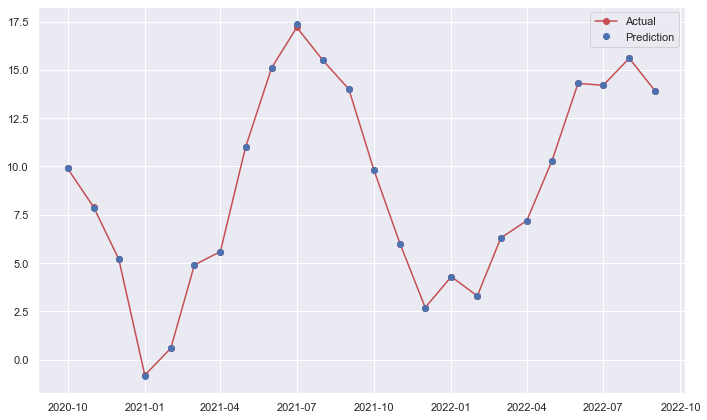

In [230]:
scale = -24
plt.plot(df.index[scale:], y[scale:], "or-", label="Actual")
plt.plot(df.index[scale:], y_pred[scale:], "ob", label="Prediction")
plt.legend()
plt.tight_layout()
plt.show()

Single Autoregressive Lag Coefficient 

In [199]:
#print(f"Autoregressive Lag Coefficient = {pipeline.named_steps.regressor.coef_[0]:4.3f}")
#pipeline.named_steps.regressor.coef_


Forecast with skits

In [231]:
y_forecast.shape

(500, 1)

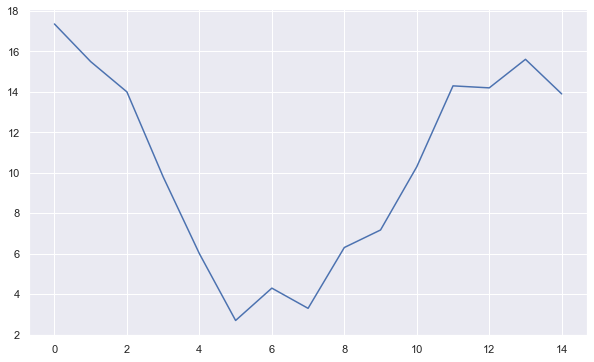

In [232]:
plt.plot(y_forecast[-15:])

In [219]:
ds_forecast = pd.date_range(start='01/10/2022', periods=24, freq="M")
df_forecast = pd.DataFrame({"date": ds_forecast, 
                            "forecast": pd.Series(list(y_forecast[-24:])).astype("float")})

#df_forecast["forecast"] = df_forecast["forecast"].astype("float")

df_forecast.info()
df_forecast.tail(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      24 non-null     datetime64[ns]
 1   forecast  24 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 512.0 bytes


,date,forecast
9,2022-10-31,17.229
10,2022-11-30,15.499
11,2022-12-31,13.998
12,2023-01-31,9.801
13,2023-02-28,6.001
14,2023-03-31,2.701
15,2023-04-30,4.301
16,2023-05-31,3.300
17,2023-06-30,6.309
18,2023-07-31,7.196


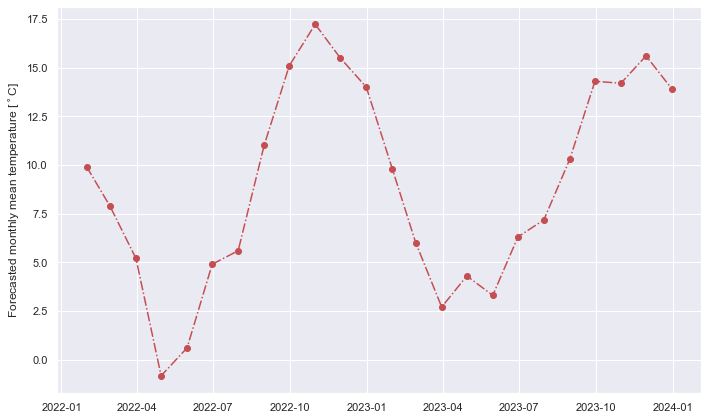

In [210]:
plt.plot(df_forecast["date"], df_forecast["forecast"], "or-.")
plt.ylabel("Forecasted monthly mean temperature [$^\circ$C]")
plt.tight_layout()
plt.show()

#### skits HorizonTransformer()

In [26]:
lin_pipeline = ForecasterPipeline([
    # Convert the `y` target into a horizon
    ('pre_horizon', HorizonTransformer(horizon=12)),
    ('pre_reversible_imputer', ReversibleImputer(y_only=True)),
    ('features', FeatureUnion([
        # Generate autoregressive features
        ("scaler", StandardScaler()),
        ('ar_features', AutoregressiveTransformer()),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', MultiOutputRegressor(LinearRegression(fit_intercept=False),
                                       n_jobs=6))
])

In [27]:
X = y.reshape(-1, 1).copy()

test_size = 689
train_size = len(X) - test_size
lin_pipeline = lin_pipeline.fit(X[:train_size], y[:train_size])


In [28]:
lin_prediction = lin_pipeline.predict(X, start_idx=train_size)
print(f'X shape: {X.shape}')
print(f'prediction shape: {lin_prediction.shape}')

X shape: (789, 1)
prediction shape: (689, 12)


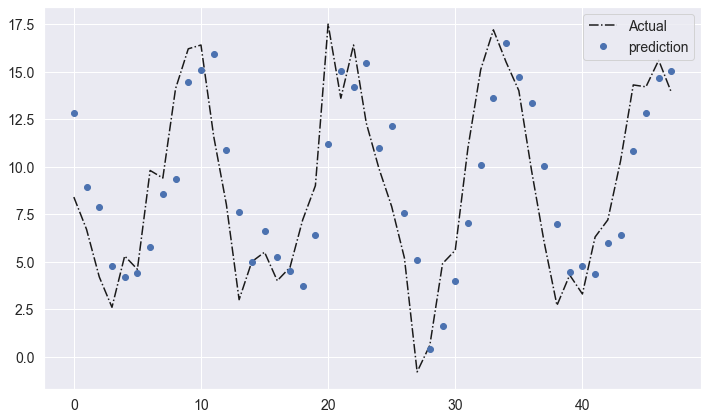

In [29]:
plt.figure();
plt.plot(y[-48:], "k-.", label="Actual")
plt.plot(lin_prediction[-48:, 11], "o", label="prediction")
plt.legend()
plt.tight_layout()
plt.show()

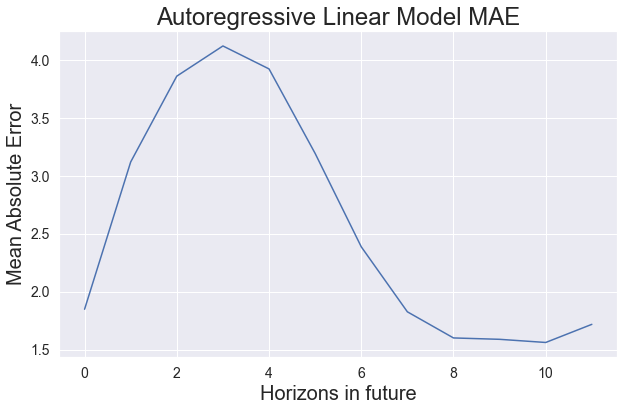

In [30]:
y_actual = lin_pipeline.transform_y(X)
lin_mae = mean_absolute_error(y_actual[-test_size:], lin_prediction,
                              multioutput='raw_values')
plt.plot(lin_mae);
plt.xlabel('Horizons in future');
plt.ylabel('Mean Absolute Error');
plt.title('Autoregressive Linear Model MAE');

In [31]:
lin_mae

array([1.84891682, 3.12103719, 3.86230934, 4.12290793, 3.92465533,
       3.19472037, 2.38829616, 1.82674004, 1.60109315, 1.58923654,
       1.56194932, 1.71857202])